Welcome to week seven of our seminar on Applied Quantitative Methods in Finance.  This week, we pivot from understanding past performance to exploring the exciting domain of forecasting. Forecasting is a crucial aspect of financial analysis and decision-making, allowing us to anticipate future trends, risks, and opportunities based on historical data and statistical models. As the famous statistician George Box aptly said, "All models are wrong, but some are useful." This highlights the inherent uncertainties in forecasting but also underscores the value of well-constructed models in providing actionable insights.

An essential principle in forecasting is to always forecast out of sample to avoid look-ahead bias. This practice ensures that our models are tested on data they have not seen before, providing a more accurate and realistic assessment of their predictive power. Throughout this week, we will delve into various forecasting techniques, learn how to build and evaluate predictive models, and understand their practical applications in finance. Get ready to enhance your predictive analytics skills and gain a deeper understanding of how to navigate the future landscape of financial markets.

Neely et al. (2014) provide excellent and well commented python code examples of their forecasting process.  This week's demonstrations use adapted parts of their code to demonstrate the steps of a typical asset returns forecasting project.  You can find the original repo that goes along with the paper here: https://github.com/kkoro/NeelyRapachZhou/tree/master

Neely, C. J., Rapach, D. E., Tu, J., & Zhou, G. (2014). Forecasting the equity risk premium: the role of technical indicators. Management science, 60(7), 1772-1791.

# Python Package Imports

In [1]:
import pandas as pd
import numpy as np

#from pandas import Series, DataFrame
import statsmodels.formula.api as smf
from IPython.display import display, HTML

# Forecast Accuracy Improvements With Simple Combination Forecasting Using Goyal Welch Indicators

In this research project, we will explore the use of a simple combination forecasting method, introduced by Rapach, Strauss and Zhou (2010), applied to the Goyal-Welch (2008) dataset, a well-regarded resource in empirical finance. The Goyal-Welch dataset provides a comprehensive collection of predictive variables that have been historically used to forecast stock returns. Our goal is to enhance the accuracy of return predictions by employing a combination forecasting approach, which leverages the strengths of multiple individual models to produce a single, more robust forecast. By combining forecasts from various models, we aim to mitigate the weaknesses of individual predictors and capitalize on their complementary strengths.

Our hypotheses are as follows: 
- H1: Combination Forecasting Improves Accuracy - The first hypothesis posits that using a combination of forecasts from multiple models will result in more accurate predictions of stock returns compared to any single model. This is based on the idea that different models capture different aspects of the data, and their combination can provide a more comprehensive and reliable forecast.
- H2: Combination Forecasting Reduces Forecast Error Variability - The second hypothesis suggests that the variability in forecast errors will be lower for the combined forecast than for individual forecasts. By aggregating predictions, we expect to smooth out the idiosyncratic errors associated with individual models, leading to more stable and consistent forecasts.
- H3: Combination Forecasting Outperforms Historical Average - The third hypothesis asserts that the combined forecasting method will outperform the simple historical average of returns. This would demonstrate the added value of leveraging multiple predictive models over relying solely on historical return averages.

This project will involve building individual forecasting models, integrating their outputs using combination techniques, and evaluating the performance of these combined forecasts against historical stock returns. Through this approach, we will evaluate the practical benefits of combination forecasting in achieving more reliable and consistent predictions in financial markets.

Rapach, D. E., Strauss, J. K., & Zhou, G. (2010). Out-of-sample equity premium prediction: Combination forecasts and links to the real economy. The Review of Financial Studies, 23(2), 821-862.

Welch, I., & Goyal, A. (2008). A comprehensive look at the empirical performance of equity premium prediction. The Review of Financial Studies, 21(4), 1455-1508.

## Preparing the Goyal Welch Forecasting Data

We use Goyal-Welch data for the forecasting process.  For detailed variable definitions and the required data transformations, you can consult the material on Amit Goyal’s website. (https://sites.google.com/view/agoyal145)  This data set is maintained by Goyal and provided via a Google Drive folder. 

The return variables are CRSP_SPvw (includes dividends) and CRSP_SPvwx (excluding dividends).This data needs to be adjusted before use, as described in the GW (2008) paper to calculate the equity premium (eq. excess returns).

A summary of the variable definitions:

- The dividend price ratio (dp), the difference between the log of dividends and the log of prices, where dividends are 12-month moving sums of dividends paid on the S&P 500 index, and prices are monthly averages of daily closing prices (Campbell and Shiller 1988; Campbell and Yogo 2006).
- Dividend yield (dy), the difference between the log of dividends and the log of lagged prices (Ball 1978).
- Earnings price ratio (ep), the difference between the log of earnings and the log of prices, where earnings are 12-month moving sums of earnings on the S&P 500 index (Campbell and Shiller 1988).
- Dividend payout ratio (de), the difference between the log of dividends and the log of earnings (Lamont 1998).
- Stock variance (svar), the sum of squared daily returns on the S&P 500 index (Guo 2006).
- Book-to-market ratio (bm), the ratio of book value to market value for the Dow Jones Industrial Average (Kothari and Shanken 1997).
- Net equity expansion (ntis), the ratio of 12-month moving sums of net issues by NYSE listed stocks divided by the total end-of-year market capitalization of NYSE stocks (Campbell, Hilscher, and Szilagyi 2008).
- Treasury bills (tbl), the 3-Month Treasury Bill: Secondary Market Rate from the economic research database at the Federal Reserve Bank at St. Louis (Campbell 1987).
- Long-term yield (lty), the long-term government bond yield from Ibbotson’s Stocks, Bonds, Bills, and Inflation Yearbook (Welch and Goyal 2008).
- Long-term rate of returns (ltr), the long-term government bond returns from Ibbotson’s Stocks, Bonds, Bills, and Inflation Yearbook (Welch and Goyal 2008).
- Term spread (tms), the difference between the long-term yield on government bonds and the Treasury bill (Campbell 1987).
- Default yield spread (dfy), the difference between BAA and AAA-rated corporate bond yields (Fama and French 1989).
- Inflation (infl), the Consumer Price Index (All Urban Consumers) from the Bureau of Labor Statistics (Campbell and Vuolteenaho 2004).

In [1]:
# download data from Amit Goyal's Google Drive folder
sheet_id = "1g4LOaRj4TvwJr9RIaA_nwrXXWTOy46bP"
sheet_name = "macro_predictors.xlsx"
macro_predictors_link = (
  f"https://docs.google.com/spreadsheets/d/{sheet_id}" 
  f"/gviz/tq?tqx=out:csv&sheet={sheet_name}"
)

goyal_welch_raw = pd.read_csv(macro_predictors_link, thousands=",")

In our analysis, we are applying several common adjustments to the raw Goyal-Welch dataset to derive meaningful predictors and facilitate robust financial forecasting. These adjustments transform the raw data into a more analyzable form by creating log-transformed ratios, spreads, and other derived metrics that are known to be effective predictors of stock returns.

Here are the key transformations and adjustments made:
- Date Conversion: Convert the yyyymm column into a datetime format to facilitate Python time-series analysis.
- Dividend-Price Ratio (Log): Calculate the dividend-price ratio using the natural logarithm of dividends divided by the index value.
- Dividend Yield (Log): Calculate the dividend yield using the natural logarithm of dividends divided by the previous month's index value.
- Earnings-Price Ratio (Log): Calculate the earnings-price ratio using the natural logarithm of earnings divided by the index value.
- Dividend Payout Ratio (Log): Calculate the dividend payout ratio by comparing the natural logarithms of dividends and earnings.
- Treasury Bill Rate: Use the annual Treasury bill rate as a predictor.
- Term Spread (Annual %): Calculate the term spread as the difference between long-term yields and short-term Treasury bill rates.
-  Default Yield Spread: Measure the difference between yields on corporate bonds of different credit ratings (BAA minus AAA).
- Long-Term Return and Yield: Use the long-term return and yield directly.
- Default Return Spread: Measure the difference between corporate bond returns and long-term government bond returns.
- Inflation (Lagged): Lag the inflation rate by one month to reflect its effect on the following month's returns.
- Total Return: Use the total return of the CRSP value-weighted index.
- Equity Premium: Calculate the equity premium as the excess return of the CRSP index over the risk-free rate.
- Equity Risk Premium Volatility: Capture the volatility of the equity premium over a rolling 12-month period.
- Risk-Free Rate (Lagged): Lag the risk-free rate by one month to apply to the following month's returns.
- Log Equity Premium: Calculate the natural logarithm of the equity premium, adjusted for small values.

In [717]:
goyal_welch_data = ( goyal_welch_raw
  .assign(
    month=lambda x: pd.to_datetime(x["yyyymm"], format="%Y%m"),
    dp=lambda x: np.log(x["D12"])-np.log(x["Index"]), # dividend-price ratio (log)
    dy=lambda x: np.log(x["D12"])-np.log(x["Index"].shift(1)), # divdend yield (log)
    ep=lambda x: np.log(x["E12"])-np.log(x["Index"]), # earnings-price ratio (log)
    de=lambda x: np.log(x["D12"])-np.log(x["E12"]), # dividend payout ratio (log)
    tbl=lambda x: x["tbl"] , # Treasury bill rate (annual)
    tms=lambda x: x["lty"]-x["tbl"],  # Term spread (annual %)
    dfy=lambda x: (x['BAA'] - x['AAA']) , # Default yield spread
    ltr=lambda x: x['ltr'] , # Long-term return 
    lty=lambda x: x['lty'] , # Long-term yield (annual)
    dfr=lambda x: x['corpr'] - x['ltr'], # Default return spread
    infl=lambda x: x['infl'].shift(1) , # Inflation (lagged)
    total_return=lambda x: x['CRSP_SPvw'] ,
    equity_premium= lambda x: (x["CRSP_SPvw"]-x["Rfree"]) ,
    rvol=lambda x: np.absolute(x['equity_premium']).rolling(12).sum(), # Equity risk premium volatility (Mele 2007, JFE)
    Rfree =lambda x: x["Rfree"].shift(1), # Rfree is end-of-month treasury bill rate divided by 12 (shifted by 1, so applies to the next month)
    log_equity_premium= lambda x: np.log1p(x['CRSP_SPvw']) - np.log1p(x['Rfree']) 
  )          
  .rename(columns={"b/m": "bm"})
  .get(["month", "dp", "dy", "ep", "de", "tbl", "tms", "dfy", "lty", "ltr", "dfr", "infl", "rvol",
        "svar", "bm", "ntis", 
        "equity_premium", 
        "log_equity_premium",
        "Rfree", 
        "total_return",
       ])
 # .query("month >= @start_date and month <= @end_date")
  .dropna()
  .set_index('month')         
)

# drop day from date
goyal_welch_data.index = goyal_welch_data.index.to_period('M')

## Forecast Functions

In this section, we delve into the practical implementation of several forecasting functions that are essential for our financial analysis and forecasting project. Accurate and robust forecasting models are the backbone of effective investment strategies, allowing us to anticipate future market movements and make informed decisions. We will define and implement a series of Python functions designed to handle various aspects of the forecasting process, including out-of-sample predictions, portfolio allocation, and advanced statistical tests like the Clark-West function. These functions will form the core tools used to generate, evaluate, and compare forecasts, ensuring that our models are both predictive and reliable. By the end of this section, you will have a comprehensive toolkit for conducting sophisticated financial forecasts, optimizing portfolios, and rigorously testing model performance.

### Out of Sample Loop Function

One of the primary functions is the single_variable_oos_forecast. This function performs out-of-sample forecasting using a simple linear regression model with a single predictor variable. It iteratively fits the model up to each point in the out-of-sample period and generates one-step-ahead forecasts. The function takes as input the dependent variable, the independent variable, and the DataFrame containing the data, along with the specified start and end dates for both the initial in-sample period and the out-of-sample forecasting period. The output is a DataFrame containing the forecasted values, residuals, and the number of observations used for each forecast.

The single_variable_oos_forecast function is designed to provide a straightforward approach to forecasting, leveraging the **statsmodels** library for regression analysis. It starts by creating an empty DataFrame to store the results, including the forecasted values, residuals, and observation counts. It then constructs the regression formula based on the specified variables and iterates through each date in the out-of-sample period. For each date, it fits the regression model using data up to that point, generates the forecast, and calculates the residual.

In [202]:
# function to create forecast based on a single variable
def single_variable_oos_forecast(y, x, df, beg_date_init, beg_date_oos, end_date_oos):
    """
    Perform out-of-sample forecasting for a given response variable using a simple linear regression model.
    
    This function iteratively fits a regression model up to each point in an out-of-sample (OOS) period
    and then makes a forecast for the next point. The function is designed to forecast one step ahead
    using lagged predictors that are already included in the dataset.

    Parameters:
    - y (str): The name of the dependent variable (response) in the DataFrame.
    - x (str): The name of the independent variable (predictor) in the DataFrame.
    - df (pandas.DataFrame): The DataFrame containing the data, indexed by date.
    - beg_date_init (str): The start date for the initial in-sample data used for fitting.
    - beg_date_oos (str): The start date for the out-of-sample forecasting period.
    - end_date_oos (str): The end date for the out-of-sample forecasting period.

    Returns:
    - pandas.DataFrame: A DataFrame indexed by date (from beg_date_oos to end_date_oos) containing:
      - 'y_forecast': The forecasted values of the dependent variable.
      - 'res': The residuals of the forecast (forecast - actual value).
      - 'obs': The number of observations used in each regression fitting up to the forecast date.
    
    Notes:
    - The data frame `df` should be preprocessed to include any necessary transformations or lagged
      variables prior to passing to this function.
    - It is assumed that the date index of the DataFrame is properly formatted and sequential.
    - This function uses the `statsmodels` library to perform regression analysis.
    """

    # create empty dataframe for the results
    oos_results = pd.DataFrame(columns=['y_forecast', 'res', 'obs'],
                               index=df[beg_date_oos:end_date_oos].index)
    
    df = df[beg_date_init:end_date_oos]

    formula =  f'{y} ~ {x}'
    print(formula)

    # loop through each set of data
    for curr_date in df[beg_date_oos:end_date_oos].index:
        # Fit the model on data up to the current date in the out-of-sample period
        df_sub = df[df.index < curr_date]
        results = smf.ols(formula, data=df_sub).fit()

        # Store the number of observations used for the fitting
        oos_results.loc[curr_date, 'obs'] = len(df_sub)

        # Forecast using the estimated coefficients and the current value of 'x'
        oos_results.loc[curr_date, 'y_forecast'] = results.params['Intercept'] + \
            results.params[x] * df.loc[curr_date, x]

        # Calculate the residual for the current forecast
        oos_results.loc[curr_date, 'res'] = oos_results.loc[curr_date, 'y_forecast'] - df.loc[curr_date, y]

    return oos_results


### Portfolio Allocation Function

The perform_asset_allocation function is a sophisticated tool designed for optimizing portfolio weights based on forecasted returns and variances. This function aligns with finance principles used in portfolio management to achieve an optimal allocation of a risky asset, taking into account various constraints and transaction costs. By adjusting the weights of the risky asset based on forecasted data, it aims to maximize the portfolio's performance while adhering to predefined risk tolerance levels.

The function operates by calculating the optimal weights for a risky asset using forecasted returns (y_hat) and return variances (var_hat), adjusting these weights within specified limits (min_wt and max_wt). It incorporates a risk aversion coefficient (gamma), which reflects the investor's tolerance for risk, and transaction costs (tc_bp), expressed in basis points. The actual returns of the asset (y) and the risk-free rate (rf) are also used to evaluate the performance of the portfolio.  It follows these steps:1
1. The transaction costs are converted from basis points to a decimal proportion, making them easier to apply in calculations.
2. Next, the function calculates the initial weights for the risky asset based on the mean-variance optimization principle. This involves dividing the forecasted returns by the product of the risk aversion coefficient and the forecasted variances. These weights are then constrained within the specified minimum and maximum limits.
3. The function calculates the total wealth and the wealth attributable to the risky asset. These calculations incorporate the risk-free rate and the adjusted weights of the risky asset.
4. It then calculates the turnover, representing the trading volume needed to maintain the target allocation, and the associated transaction costs.
5. The final portfolio returns are adjusted for transaction costs. This adjustment ensures that the returns reflect the true performance after accounting for the cost of trading.

The function also calculates key performance metrics:
- Average Utility: This is the mean return adjusted for risk aversion, representing the investor's satisfaction with the portfolio's performance.
- Sharpe Ratio: This metric measures the portfolio's risk-adjusted return, indicating how much excess return is achieved per unit of risk.
- Cumulative Return: The overall return of the portfolio over the period, compounded to reflect the growth of the investment.
- Average Turnover: This measures the average trading volume, providing insight into the frequency and volume of trades.

In summary, the perform_asset_allocation function is a comprehensive tool for evaluating and optimizing portfolio weights. By incorporating forecasted returns, variances, and transaction costs, it provides a realistic and practical approach to portfolio management, helping investors achieve their desired balance of risk and return.

In [526]:
def perform_asset_allocation(y, rf, y_hat, var_hat, gamma, tc_bp, min_wt=0, max_wt=1.5):
    """
    Perform asset allocation evaluation based on a model similar to that used in finance
    for optimizing portfolio weights according to forecast returns and variances.

    This function calculates optimal weights for a risky asset based on forecast returns and
    return variances, adjusts these weights based on given constraints (minimum and maximum weights),
    and calculates various portfolio performance metrics, accounting for transaction costs.

    Parameters:
    - y (numpy.array): T-vector of actual returns for the asset.
    - rf (numpy.array): T-vector of risk-free rates for each period.
    - y_hat (numpy.array): T-vector of forecast returns for the asset.
    - var_hat (numpy.array): T-vector of forecast return variances for the asset.
    - gamma (float): Risk aversion coefficient, a positive value where higher values indicate higher aversion.
    - tc_bp (float): Transaction costs expressed in basis points.
    - min_wt (float, optional): Minimum weight or allocation allowed for the risky asset. Default is 0.
    - max_wt (float, optional): Maximum weight or allocation allowed for the risky asset. Default is 1.5.

    Returns:
    - dict: A dictionary containing:
      - 'avg_utility': Average utility value of the portfolio, considering returns and risk aversion.
      - 'SR': Sharpe ratio of the portfolio, adjusted for the risk-free rate.
      - 'cum_return': Cumulative (gross) return of the portfolio over the period.
      - 'avg_turnover': Average turnover of the portfolio, indicating the frequency and volume of trading.

    Notes:
    - Transaction costs are adjusted by dividing by 10,000 to convert basis points to a proportion.
    - The function assumes all input arrays are of equal length and correctly aligned by date.
    - The utility function used is mean return minus half the variance of returns scaled by risk aversion (mean-variance utility).
    - This function does not handle edge cases for data input, such as empty arrays or non-numeric inputs.
    """
    # Convert transaction costs from basis points to a decimal proportion
    tc_bp = tc_bp / 10000
    T = len(y)

    # Calculate initial risky asset weights based on forecasts and risk aversion
    weight_risky = 1 / gamma * y_hat / var_hat
    weight_risky[weight_risky < min_wt] = min_wt
    weight_risky[weight_risky > max_wt] = max_wt

    # Calculate wealth and returns adjusted for transaction costs and weights
    wealth_total = 1 + rf + weight_risky * y
    wealth_risky = weight_risky * (1 + rf + y)

    # Calculate turnover and transaction costs
    target_risky = weight_risky.shift(-1) * wealth_total
    turnover = np.absolute(target_risky - wealth_risky) / wealth_total
    tc = tc_bp * turnover

    # Final portfolio returns, adjusted for costs
    portfolio_return = wealth_total * (1 - tc) - 1
    portfolio_return.iloc[-1] = rf.iloc[-1] + weight_risky.iloc[-1] * y.iloc[-1]

    # Calculate utility and performance metrics
    avg_utility = portfolio_return.mean() - 0.5 * gamma * np.power(portfolio_return.std(), 2)
    excess_portfolio_return = portfolio_return - rf
    SR = excess_portfolio_return.mean() / excess_portfolio_return.std()
    #cum_return = np.cumprod(portfolio_return + 1).iloc[-1]
    cum_return = np.cumprod(1+portfolio_return ) - 1

    # Aggregate results
    results =  {'metrics':
                    {'avg_utility': avg_utility * 100, 
                   'Sharpe_ratio': SR, 
                   'cum_return': cum_return.iloc[-1],
                   'avg_turnover': turnover.mean()},
                'cumret': cum_return}
    
    return results

### Clark-West Function

The perform_cw_test function is designed to implement the Clark-West (2007) test, which compares the predictive accuracy of forecasts from nested models. This test is particularly useful in econometrics and financial modeling for evaluating whether a more complex, unrestricted model significantly improves forecast accuracy over a simpler, restricted model.

The function provides a rigorous method for evaluating the predictive accuracy of nested models, helping researchers determine if a more complex forecasting model offers a statistically significant improvement over a simpler one. By incorporating this test, we can make more informed decisions about the models we use for forecasting and ensure that any added complexity is justified by better performance.

T.E. Clark and K.D. West (2007). "Approximately Normal Tests for Equal Predictive Accuracy in Nested Models." Journal of Econometrics 138, 291-311.

In [435]:
import numpy as np
from scipy.stats import norm

def perform_cw_test(actual, restricted, unrestricted):
    """
    Perform the Clark-West (2007) test to compare forecasts from nested models.
    
    This function calculates the Mean Squared Forecast Error (MSFE) adjustment and
    the corresponding p-value to determine if the unrestricted model offers better
    predictive performance compared to the restricted model.

    Parameters:
    - actual (numpy.array): Vector of actual observed values.
    - restricted (numpy.array): Vector of forecasted values from the restricted model.
    - unrestricted (numpy.array): Vector of forecasted values from the unrestricted model.

    Returns:
    - dict: A dictionary containing:
      - 'msfe_adj': The Clark-West statistic indicating the adjusted forecast error difference.
      - 'p_value': The p-value associated with the MSFE adjustment, indicating statistical significance.

    """

    e1 = actual - restricted
    e2 = actual - unrestricted
    f_hat = np.power(e1, 2) - (np.power(e2, 2) - np.power(restricted - unrestricted, 2))
    Y_f = f_hat
    X_f = np.ones((len(Y_f), 1))

    beta_f = np.dot(np.linalg.inv(np.dot(np.transpose(X_f), X_f)), (np.dot(np.transpose(X_f), Y_f)))
    e_f = Y_f - np.dot(X_f, beta_f)
    sig2_e = np.dot(e_f, e_f) / (len(Y_f) - 1)
    cov_beta_f = np.dot(sig2_e, np.linalg.inv(np.dot(np.transpose(X_f), X_f)))
    msfe_adj = beta_f / np.sqrt(cov_beta_f)
    p_value = 1 - norm.cdf(msfe_adj[(0,0)])
    
    return {'msfe_adj':msfe_adj[(0,0)], 'p_value':p_value}

## Calculating Forecasts

In this section, we delve into the process of calculating financial forecasts using various predictor variables from the Goyal-Welch dataset. By setting specific parameters and implementing out-of-sample forecasting techniques, we aim to generate accurate predictions of the equity premium. This section provides a step-by-step approach to setting up the forecasting environment, generating individual forecasts, and combining them to enhance predictive accuracy.

First, we define the key parameters for our forecasting exercise.  We set the initial period to begin in December 1950, with the out-of-sample forecasting starting in January 1966 and ending in December 2022. This allows us to establish a substantial training period and a comprehensive out-of-sample evaluation period.

We calculate the number of observations in the initial training period, which we feed to our function later.

We define a risk aversion parameter $\gamma$ (gamma_MV) and transaction costs (c_bp) to be used in portfolio optimization later.

The window size is set to 5 years (60 months) for calculating rolling forecasts.

In [512]:
# Set forecasting parameters
beg_date_init = '1950-12'
beg_date_oos = '1966-01'
end_date_oos = '2022-12'

# size of initial training period
init_obs = len(pd.date_range(beg_date_init, beg_date_oos, freq='ME'))

# Risk aversion paramter
gamma_MV = 5

# transactions cost in basis points
c_bp = 500

# size of rolling window for vol forecast
window_size = 5 * 12


We define the predictor variables and the dependent variable for forecasting.

In [513]:
# assign the dataset 
df = goyal_welch_data

# define the x-variables
predictors_ = ["dp", "dy", "ep", "de", "tbl", "tms", "dfy", "lty", "ltr", "dfr", "infl", "rvol", "svar", "bm", "ntis"]

y_ = 'equity_premium'

The predictor variables are lagged by one period to ensure that the forecasts are out-of-sample, reflecting information available at the time of prediction.

In [514]:
# lag the x variables by one observation, we forecast out of sample and won't know returns until next period
df[predictors_] = df[predictors_].shift(1)

We loop through each predictor variable to generate forecasts using the single_variable_oos_forecast function we have previously defined. 

In [515]:
%%time

# create list to collect individual predictions
predictions_ = []
residuals_ = []

# generate forecasts for each variable separately
for x_var in predictors_:#[0:2]:

    # generate predictions
    prediction = single_variable_oos_forecast(y_, x_var, df, beg_date_init,
        beg_date_oos, end_date_oos)

    # collect all individual predictions and rename the forecasts to the x-variable that it is based on
    predictions_.append(
        prediction.get(['y_forecast']).rename(columns={'y_forecast':x_var}))

    # collect residuals
    residuals_.append(
        prediction.get(['res']).rename(columns={'res':x_var}))
    

equity_premium ~ dp
equity_premium ~ dy
equity_premium ~ ep
equity_premium ~ de
equity_premium ~ tbl
equity_premium ~ tms
equity_premium ~ dfy
equity_premium ~ lty
equity_premium ~ ltr
equity_premium ~ dfr
equity_premium ~ infl
equity_premium ~ rvol
equity_premium ~ svar
equity_premium ~ bm
equity_premium ~ ntis
CPU times: user 27.7 s, sys: 19.4 ms, total: 27.7 s
Wall time: 27.7 s


In [516]:
# combine the predictions and residuals in one data frame
predictions_ = pd.concat(predictions_, axis=1, join='outer')
residuals_ = pd.concat(residuals_, axis=1, join='outer')

Finally, we generate the Simple Combination Forecast (scf_mean), calculated as the average of the individual forecasts.  We use the mean function here, but other functions such as trimmed means or medians can be used as well.  We also compute the residuals for this combined forecast to evaluate its accuracy. 

In [517]:
# calculate combination forecast
predictions_['scf_mean'] = predictions_.mean(axis=1)

# calculate scf model residuals and add them to the residuals list for all models
residuals_ = residuals_.join(
        ( predictions_
             .join(df.get(y_))
             .assign(scf_mean = lambda x: x['scf_mean'] - x[y_]) 
             .get(["scf_mean"])  
        )) 

## Performance Evaluation

In this section, we focus on evaluating the performance of our returns forecasting models using a combination of statistical and investment metrics. The goal is to comprehensively assess the predictive power and practical value of the models we have developed. By analyzing fit metrics, cumulative sum plots, and investment performance graphs, we can gain insights into the strengths and limitations of our forecasting approaches and make informed decisions about their applicability in real-world investment scenarios.

### Fit Metrics Table

In this section, we calculate and compile various fit metrics for our forecasting models, comparing them against a historical average benchmark. These metrics allow us to quantitatively evaluate the performance of each model, focusing on their predictive accuracy and investment utility.

We begin by selecting the relevant data for the specified date range to ensure our analysis is focused and accurate.

In [ ]:
# select data for specified date range
df_sub = df[beg_date_init:end_date_oos].copy()

Next, we calculate the historical average forecast, which serves as a benchmark for comparing the performance of our forecasting models. The historical average forecast is computed as the expanding mean of the equity premium, shifted by one period to ensure it is out-of-sample. We also calculate the residuals and rolling variance of the historical average forecast.

In [519]:
# historical average (ha) benchmark
ha_forecast = df[y_].expanding( min_periods=window_size).mean()
ha_forecast = ha_forecast.shift(1)[beg_date_oos:end_date_oos] # historical mean is forecast for the next period
ha_residuals = df_sub[y_][beg_date_oos:end_date_oos] - ha_forecast[beg_date_oos:end_date_oos]
ha_var = df_sub[y_].rolling(window=window_size, min_periods=window_size).var(ddof=0).shift(1)[beg_date_oos:end_date_oos:]

In [693]:
model_fit_stats = pd.DataFrame()
investment_returns = {}

We calculate key fit statistics for the historical average benchmark, including the Mean Squared Forecast Error (MSFE) and out-of-sample R-squared. We also perform asset allocation using the historical average forecasts with zero transaction costs and compile these metrics into a comprehensive dictionary.

In [694]:
# calculate fit statistics for benchmark
ha_fit_metrics = {}
ha_fit_metrics['model']= 'recursive HA'
ha_fit_metrics['msfe']= np.mean(np.power(ha_residuals, 2))
ha_fit_metrics['r2oos'] = (1 - ha_fit_metrics['msfe'] / ha_fit_metrics['msfe']) * 100

# Perform asset allocation using historical average forecasts using zero transaction costs c_bp = 0
ha_results = perform_asset_allocation(df_sub['equity_premium'], df_sub['Rfree'],
	        ha_forecast, ha_var, gamma_MV, 0)

combined_fit_metrics = {**ha_fit_metrics, **ha_results['metrics']}
combined_fit_metrics['model']= 'recursive HA'
model_fit_stats = pd.concat([model_fit_stats, pd.DataFrame(combined_fit_metrics, index=[0])])
investment_returns['recursive HA'] = ha_results['cumret']


For each forecasting model, we calculate the fit statistics, including MSFE and out of sample R-squared, and perform the Clark-West test to assess the model's predictive accuracy relative to the historical average benchmark. We also perform asset allocation using the forecasts from each model, computing various performance metrics such as the Certainty Equivalent Return (CER) and relative turnover. 

In [695]:
log_y = df.loc[beg_date_oos:end_date_oos,'log_equity_premium']

for model_ in residuals_.columns:

    fit_metrics = {}
    
    # calculate fit statistics for model
    fit_metrics['model']= model_
    fit_metrics['msfe']= np.mean(np.power(residuals_[model_], 2))
    fit_metrics['r2oos'] = (1 - fit_metrics['msfe'] / ha_fit_metrics['msfe']) *100
    
    cw_stat = perform_cw_test(log_y, residuals_.loc[beg_date_oos:end_date_oos,model_], ha_forecast[beg_date_oos:end_date_oos])
    fit_metrics['msfe_adj'] = cw_stat['msfe_adj']
    fit_metrics['p_value'] = cw_stat['p_value']

    # Perform asset allocation using historical average forecasts using zero transaction costs
    model_sim = perform_asset_allocation(df_sub['equity_premium'], df_sub['Rfree'],
        	        predictions_[model_], ha_var, gamma_MV, 0)

    # Certainty Equivalent Return (CEO) is a financial metric used to measure the utility of an investment, 
    # taking into account the investor's risk aversion. Essentially, it quantifies the guaranteed return that an 
    # investor would accept instead of a risky investment with a higher potential return.
    model_sim['metrics']['CER'] = (model_sim['metrics']['avg_utility'] - ha_results['metrics']['avg_utility']) * 12
    model_sim['metrics']['rel turnover'] = model_sim['metrics']['avg_turnover'] / (ha_results['metrics']['avg_turnover'] + 1e-5 )

    combined_fit_metrics = {**fit_metrics, **model_sim['metrics']}
    model_fit_stats = pd.concat([model_fit_stats, pd.DataFrame(combined_fit_metrics, index=[0])])
    investment_returns[model_] = model_sim['cumret']


In [696]:
model_fit_stats

,model,msfe,r2oos,avg_utility,Sharpe_ratio,cum_return,avg_turnover,msfe_adj,p_value,CER,rel turnover
0,recursive HA,0.001955,0.000000,0.323565,0.090668,81.724543,0.022745,NaN,NaN,NaN,NaN
0,dp,0.001963,-0.444327,0.292303,0.059297,30.324064,0.042427,14.460811,0.0,-0.375152,1.864547
0,dy,0.001963,-0.443887,0.323468,0.064145,32.639084,0.058625,14.484409,0.0,-0.001174,2.576392
0,ep,0.001971,-0.815205,0.349701,0.083069,56.405607,0.035740,14.195369,0.0,0.313622,1.570650
0,de,0.001971,-0.823115,0.315043,0.074791,46.244789,0.042436,13.752211,0.0,-0.102275,1.864920
0,tbl,0.001973,-0.940911,0.464327,0.121199,169.344641,0.031670,13.721861,0.0,1.689138,1.391823
0,tms,0.001974,-0.990675,0.477853,0.136405,364.548051,0.085540,13.644528,0.0,1.851446,3.759250
0,dfy,0.001968,-0.680788,0.277933,0.084652,72.895962,0.051010,13.955374,0.0,-0.547584,2.241743
0,lty,0.001972,-0.862906,0.451730,0.112829,117.468774,0.023078,13.786198,0.0,1.537971,1.014211
0,ltr,0.001952,0.115114,0.416654,0.120733,222.964656,0.483348,14.248883,0.0,1.117059,21.241777


The performance evaluation of the forecasting models highlights the key metrics and benefits of using the SCF mean approach compared to the recursive historical average (HA) benchmark.

The recursive HA model serves as a baseline for comparison. It has a Mean Squared Forecast Error (MSFE) of 0.001955, with an out-of-sample R-squared of 0, indicating that it does not provide additional explanatory power over itself. The average utility of the portfolio based on this model is 0.32, with a Sharpe ratio of 0.09. The cumulative return over the period is substantial at 81.72%, reflecting a stable performance. However, the average turnover is relatively low at 0.0227, suggesting that the model does not require frequently rebalancing.

The SCF mean model, which combines forecasts from multiple predictors, shows a significant improvement over the recursive HA model. It has a lower MSFE of 0.001940 and a notably higher out of sample R-square of 0.77, indicating better out-of-sample predictive accuracy. The average utility for the SCF mean model is also higher at 0.47, reflecting greater investor satisfaction. The Sharpe ratio of 0.12 indicates a better risk-adjusted return compared to the HA model. Although the cumulative return of 117.23% is slightly lower than some other individual predictors, it is significantly higher than the HA model, showing robust performance. The average turnover is higher at 0.0812, indicating more frequent rebalancing, but this is justified by the improved returns and utility.

In conclusion, the SCF mean approach offers substantial benefits over the recursive HA model by providing more accurate forecasts, higher utility, better risk-adjusted returns, and improved cumulative performance, making it a more effective tool for portfolio optimization and financial forecasting.

### Goyal-Welch CumSum Plot

The Goyal-Welch cumulative sum (CumSum) plot is a powerful visualization tool used to compare the performance of different forecasting models over time. It shows the cumulative difference in the squared residuals of each model against a benchmark, highlighting periods where each model performs better or worse relative to the benchmark. This section involves calculating these cumulative sums and then plotting them to assess model performance visually.

In [647]:
from plotnine import ggplot, aes, geom_line, geom_point, theme_minimal, geom_text, scale_x_date, theme, geom_ribbon, labs
from mizani.formatters import date_format

The first step involves calculating the cumulative sum of squared differences between the residuals of each forecasting model and the historical average (HA) benchmark.

In [635]:
# calculate the cumulative Sum of Square Difference for Goyal-Welch plot
ha_residuals.name = "ha_residuals"
gw_cumsum = residuals_.join(ha_residuals)
for column_ in residuals_.columns:
    gw_cumsum[column_] = pd.to_numeric ( np.cumsum(gw_cumsum['ha_residuals']**2) - np.cumsum(gw_cumsum[column_]**2) )
gw_cumsum = gw_cumsum.drop(columns='ha_residuals')
gw_cumsum['date'] = pd.to_datetime(gw_cumsum.index.to_timestamp())
gw_cumsum = gw_cumsum.melt(id_vars=['date'], var_name='model', value_name='residual_difference_cumsum')

The first plot focuses specifically on the SCF mean model, allowing us to see how this combination forecasting model performs over time relative to the HA benchmark.

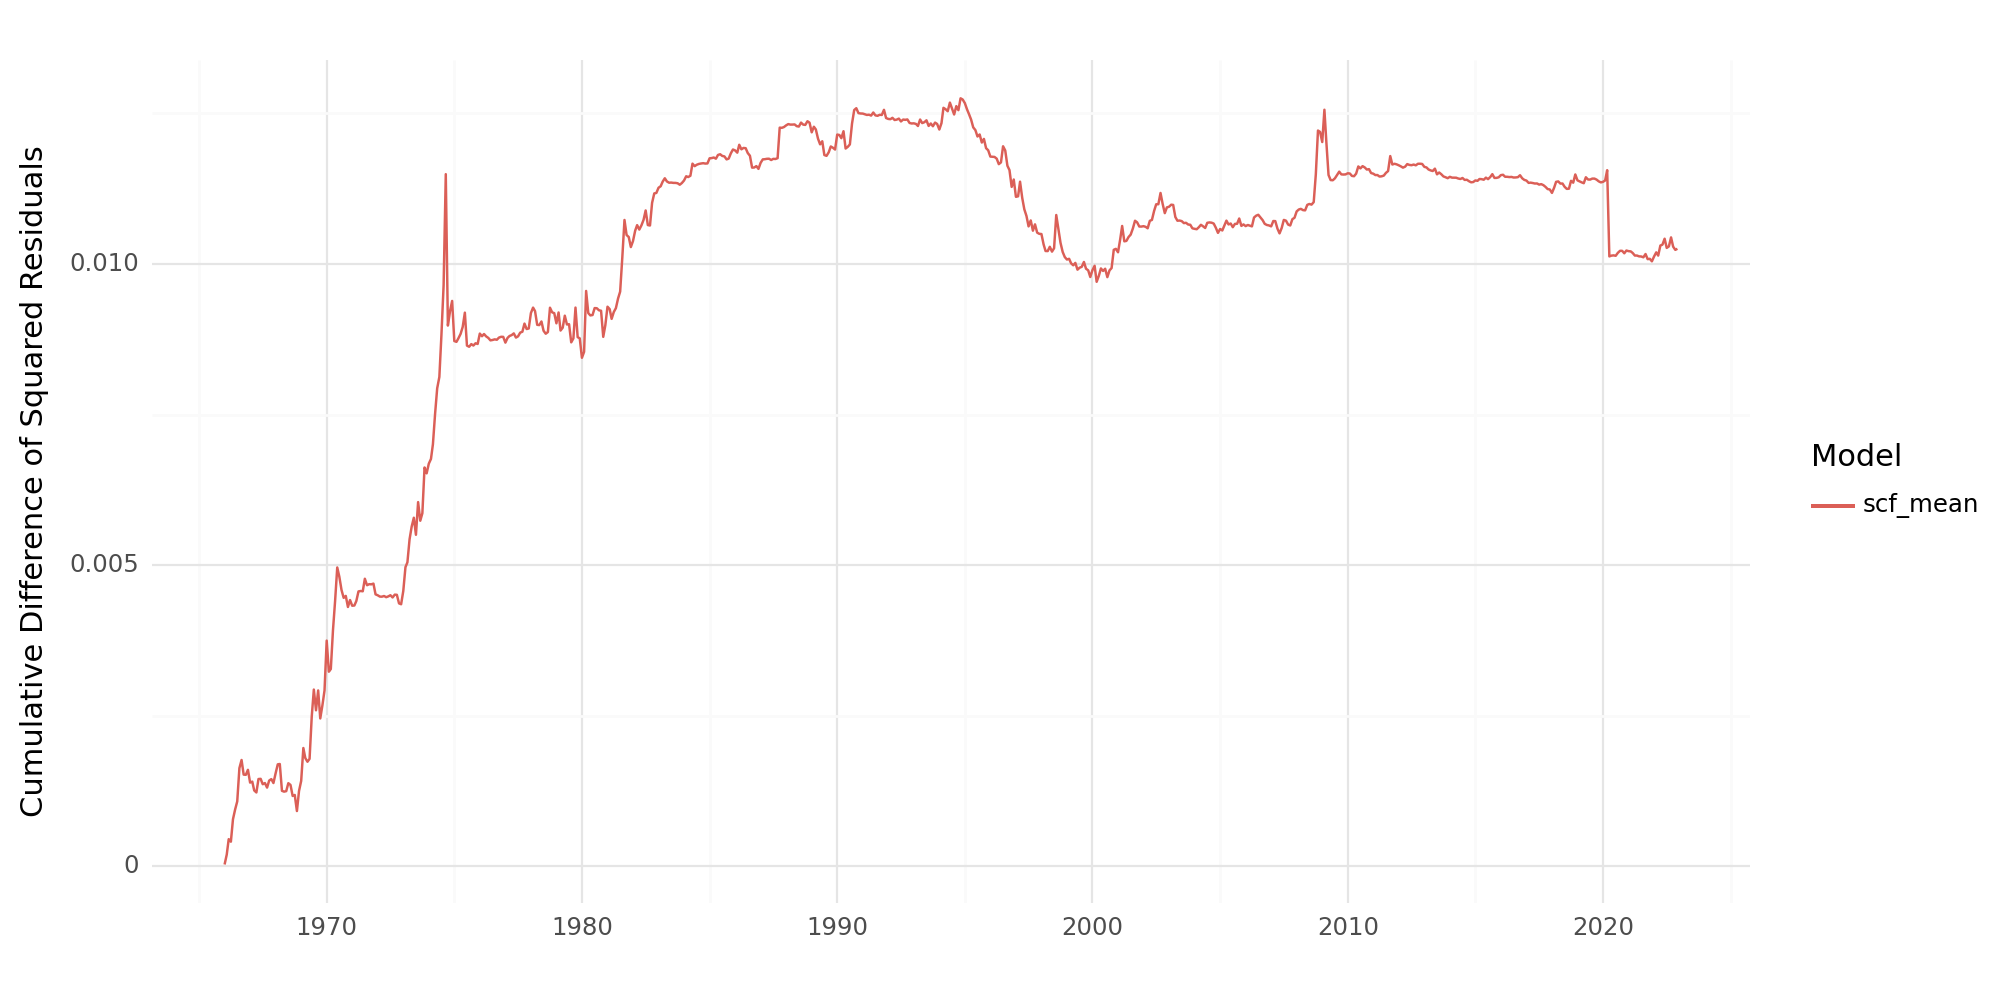

<Figure Size: (1000 x 500)>

In [735]:
(
    ggplot(data = gw_cumsum.loc[gw_cumsum.model.isin(['scf_mean'])]) 
    + aes(x="date", y="residual_difference_cumsum", color="model")         
    + geom_line()           
    + theme_minimal()
    + scale_x_date(labels=date_format('%Y'))
    + labs(
        x="",  # Label for the x-axis
        y="Cumulative Difference of Squared Residuals",  # Label for the y-axis
        color="Model"  # Label for the color legend
      )
    + theme( figure_size=(10, 5))
)

The second plot includes all forecasting models, providing a comprehensive view of their performance relative to the HA benchmark.

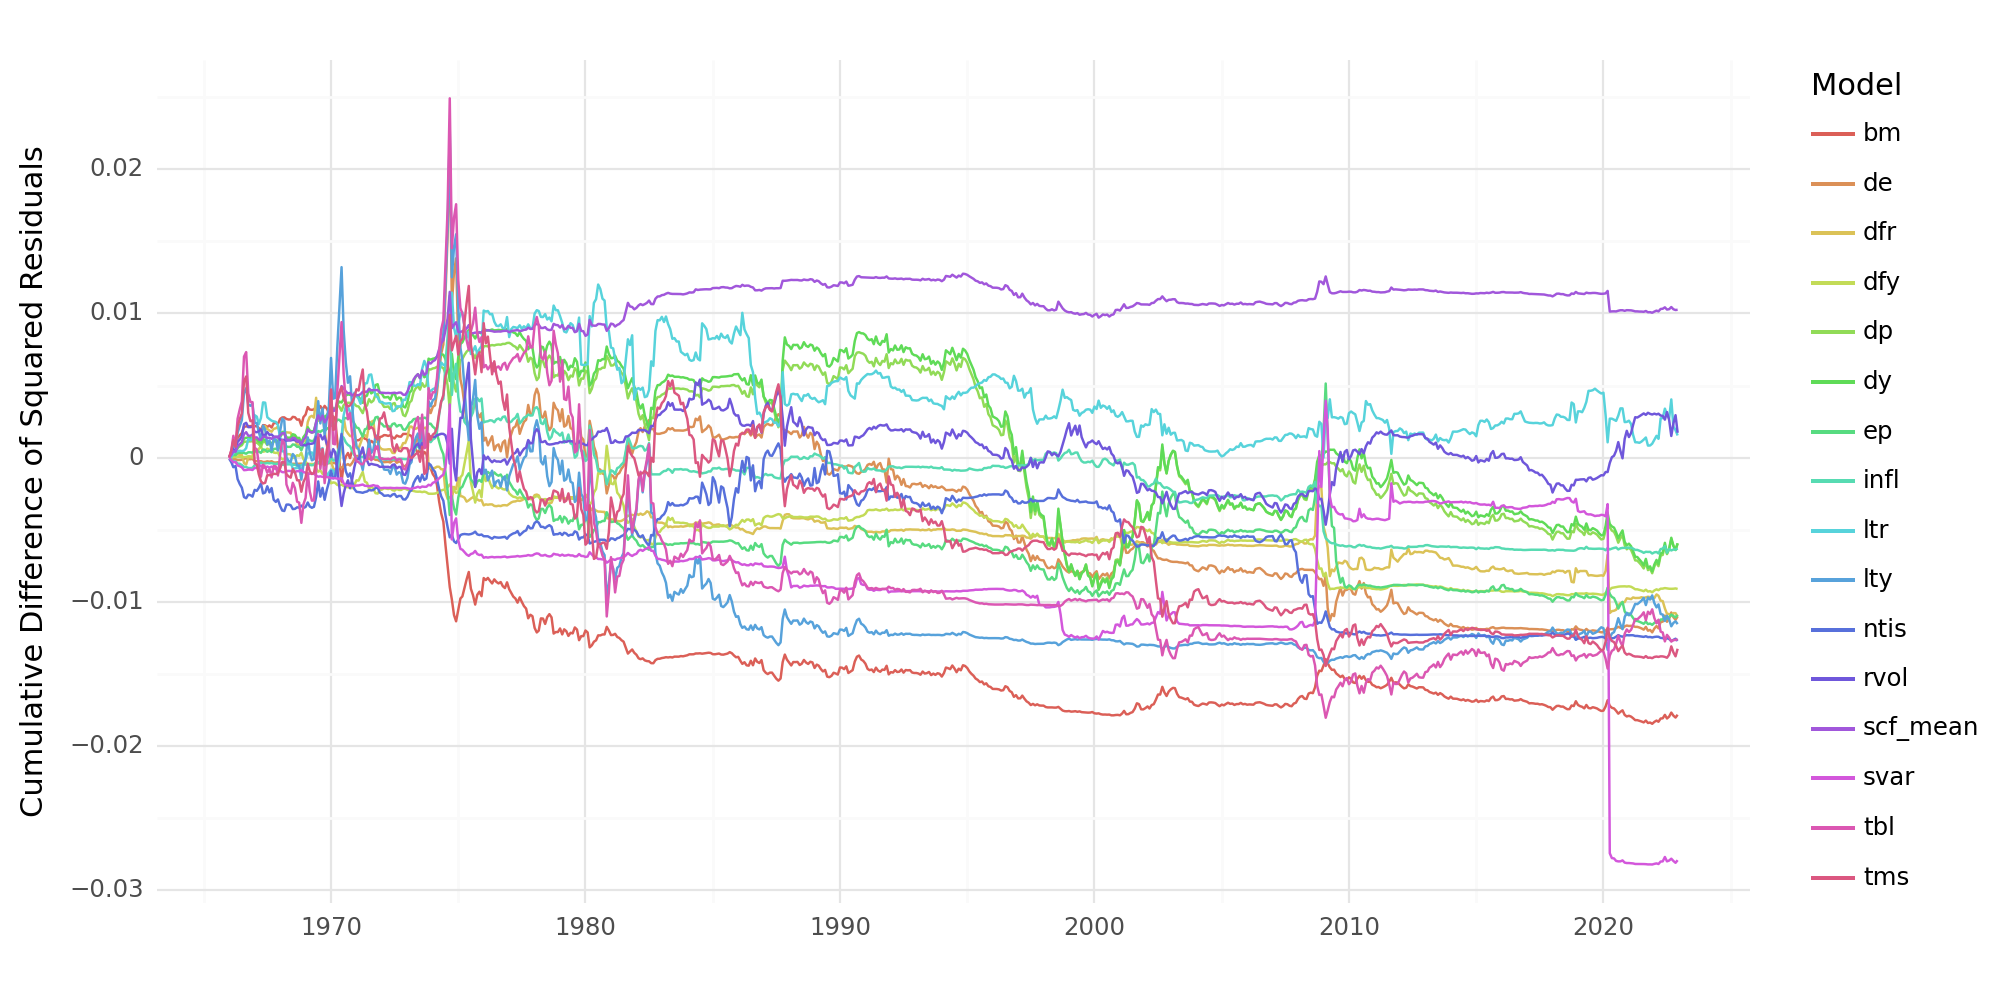

<Figure Size: (1000 x 500)>

In [737]:
(
    ggplot(data = gw_cumsum) 
    + aes(x="date", y="residual_difference_cumsum", color="model")         
    + geom_line()           
    + theme_minimal()
    + scale_x_date(labels=date_format('%Y'))
    + labs(
        x="",  # Label for the x-axis
        y="Cumulative Difference of Squared Residuals",  # Label for the y-axis
        color="Model"  # Label for the color legend
      )
    + theme( figure_size=(10, 5))
)

In the first graph, we see that the cumulative difference in squared residuals between the SCF mean model and the historical average (HA) benchmark shows a steadily increasing trend from the mid-1950s through the late 1990s, indicating that the SCF mean model consistently outperformed the HA benchmark over this period. However, from the early 2000s onwards, the performance shows more stability and a slight decline, suggesting a diminishing outperformance relative to the HA benchmark. This trend implies that while the SCF mean model initially provided substantial predictive improvement, its relative advantage over the HA model has stabilized or slightly decreased in recent years.

The second plot includes all forecasting models, providing a comparative view of their cumulative squared residual differences against the HA benchmark. Here are some key observations:

- The SCF mean model continues to show strong performance, with its cumulative residual differences generally staying positive. This indicates that the SCF mean model is consistently performing better than the HA benchmark, especially noticeable during the volatile periods of the 1970s and 1980s.
- The bm model shows a negative cumulative difference, indicating it generally performed worse than the HA benchmark.
- tms (Term Spread) and rvol (Realized Volatility) show mixed performance with periods of both positive and negative cumulative differences. This suggests their performance relative to the HA benchmark is more variable and potentially dependent on specific market conditions.
- dy (Dividend Yield) and dp (Dividend Price Ratio) show relatively stable cumulative differences, indicating moderate and consistent performance improvements over the HA benchmark, though not as pronounced as the SCF mean model.

Overall, the SCF mean model stands out for its robust and consistent outperformance over the HA benchmark across the entire observation period. This reinforces the benefits of using a combination forecasting approach, which leverages multiple predictors to enhance predictive accuracy and provide more reliable forecasts. Other models, while useful, show varying degrees of effectiveness, highlighting the importance of model selection based on the specific economic and market context.

### Investment Performance Graph

We also examine the investment performance of the forecasting models through graphical representations. These graphs illustrate how the forecasts translate into investment returns, comparing the performance of different models against benchmarks and each other. This analysis helps us understand the practical implications of using these models in a portfolio context.

We calculate the buy and hold returns for the specified period (beg_date_oos to end_date_oos). The buy and hold strategy involves purchasing an asset and holding it for a long period, without trading. Here, the cumulative product of the returns is computed and adjusted by subtracting 1 to reflect the total return over the period.

In [728]:
# calculate buy and hold returns for comparison
buy_and_hold = np.cumprod( 1+ goyal_welch_data["total_return"][beg_date_oos:end_date_oos] ) -1

Then we prepare the data for plotting cumulative returns of different models. These steps set the stage for generating visualizations that compare the cumulative returns of different investment strategies, allowing for a clear comparison of performance over time.

In [729]:
inv_ret_plotting_df = ( 
    pd.DataFrame({"Buy and Hold" : pd.to_numeric(  buy_and_hold ),
                  "recursive HA" : pd.to_numeric( investment_returns['recursive HA']),
                  "recursive SCF (mean)" : pd.to_numeric( investment_returns['scf_mean']),
                  "tms" : pd.to_numeric( investment_returns['tms'])})
         .assign(
             date = pd.to_datetime(investment_returns['recursive HA'].index.to_timestamp())
         )
         .dropna()
         .melt(id_vars=['date'], var_name='model', value_name='Cumulative Returns')
)

Here we create the time series graph including all the selected investment strategies.

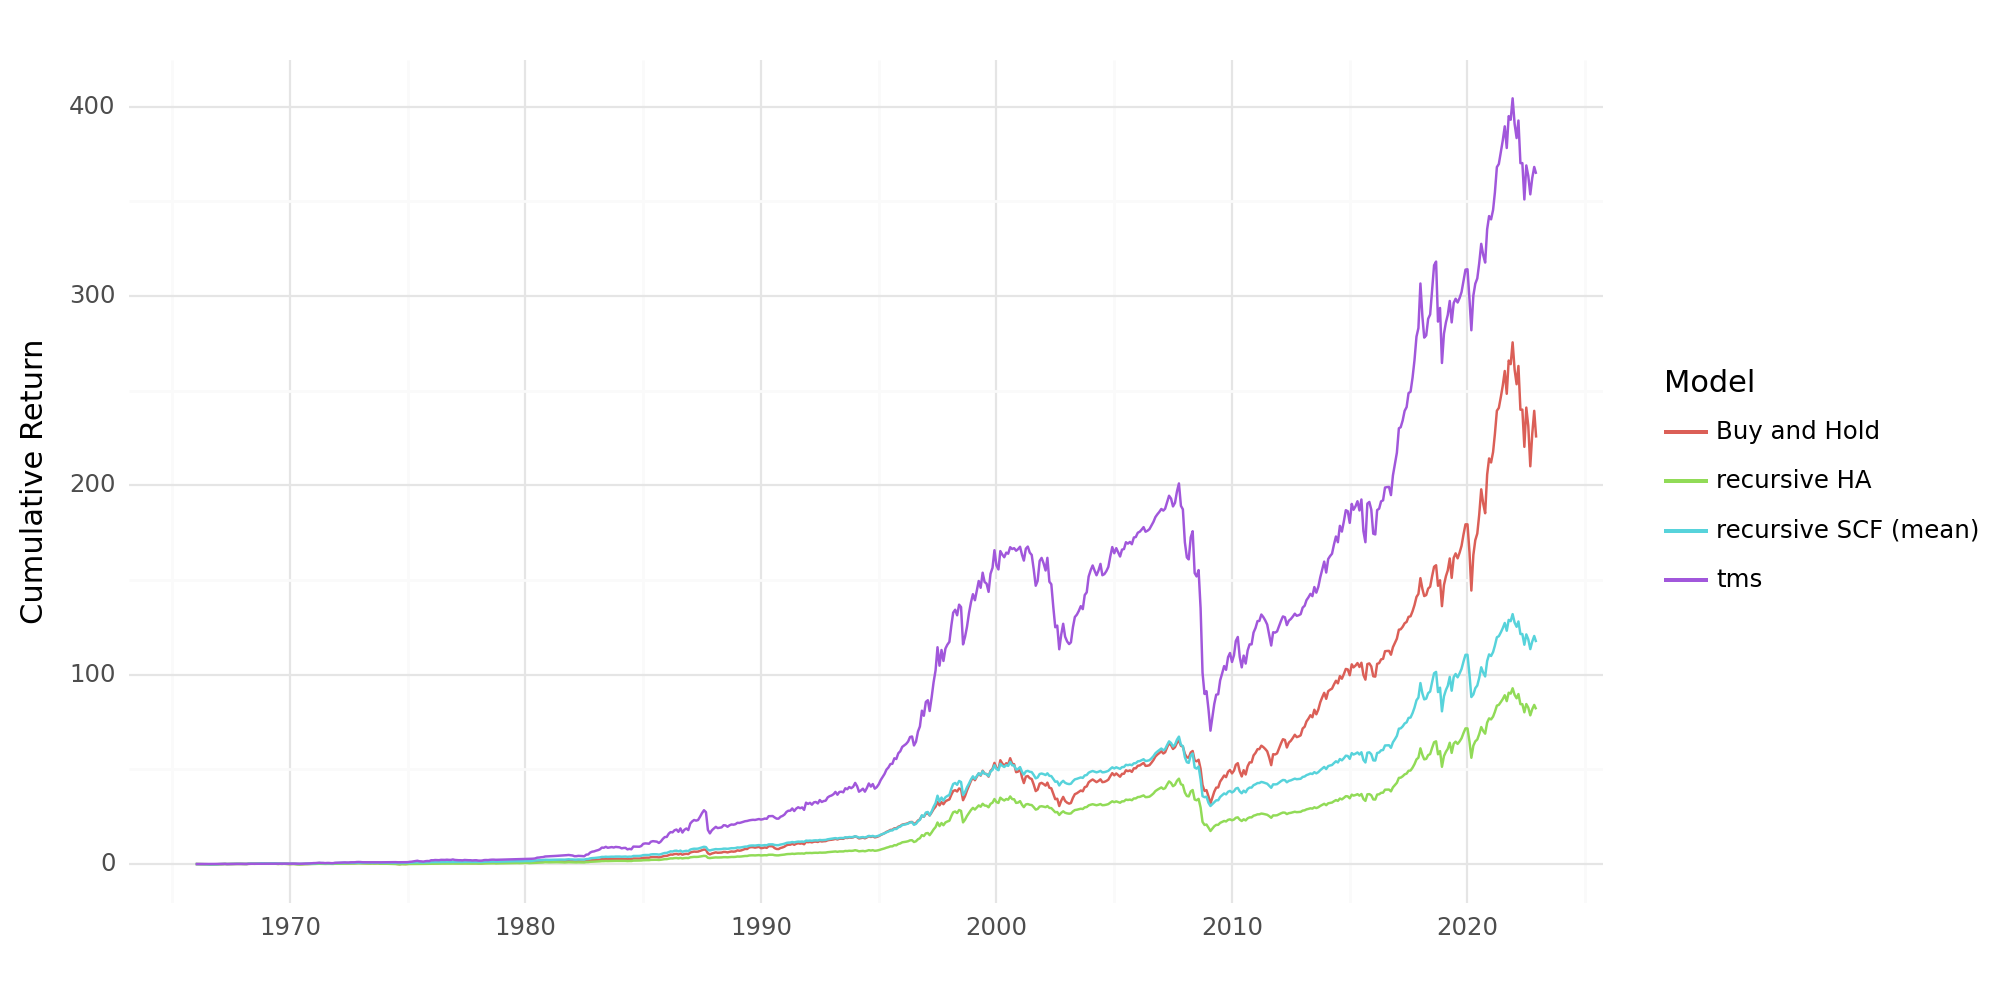

<Figure Size: (1000 x 500)>

In [734]:
(
    ggplot(data = inv_ret_plotting_df) 
    + aes(x="date", y="Cumulative Returns", color="model")         
    + geom_line()           
    + theme_minimal()
    + scale_x_date(labels=date_format('%Y'))
    + labs(
        x="",  # Label for the x-axis
        y="Cumulative Return",  # Label for the y-axis
        color="Model"  # Label for the color legend
      )
    + theme( figure_size=(10, 5))
)

The graph displays the cumulative returns for various investment models over time, comparing the "Buy and Hold", "recursive HA", "recursive SCF (mean)", and "tms" strategies. The "Buy and Hold" strategy, represented in red, serves as a baseline for comparison. The "recursive HA" (Historical Average) model, shown in green, maintains a relatively steady growth, closely mirroring the performance of the "Buy and Hold" strategy for much of the period.

The "recursive SCF (mean)" model, depicted in light blue, employs a combination forecasting method. Although it demonstrates robustness and a consistent upward trajectory, it does not outperform the "Buy and Hold" strategy, indicating that while the combination approach is reliable, it does not necessarily yield the highest returns.

The "tms" (term spread) model, shown in purple, significantly outperforms the other models over the long term, demonstrating substantial cumulative returns, especially noticeable from the mid-1980s onwards. This suggests that the term spread is a particularly effective predictor in this context, offering superior returns compared to both the combination forecasting method and the historical average approach. However, the substantial variability and higher peaks of the "tms" model also indicate greater volatility and risk.

In summary, while the "recursive SCF (mean)" model is robust and consistent, it does not achieve the highest returns, falling short of outperforming the "Buy and Hold" strategy. On the other hand, the "tms" model exhibits the highest performance, albeit with increased volatility, highlighting the trade-offs between different forecasting approaches in portfolio management.

## Results

The results from our analysis provide insight into the three initial hypotheses concerning the efficacy of combination forecasting. The cumulative sum of squared residuals (CumSum) plots and investment performance metrics reveal key aspects of these hypotheses.

Regarding H1, which posits that combination forecasting improves accuracy, the CumSum plots show that the SCF mean model consistently outperforms most individual predictors in terms of residuals over time. The SCF mean model generally has a lower cumulative sum of squared residuals, indicating more accurate predictions compared to individual models. This supports the hypothesis that combining forecasts from multiple models yields a more accurate prediction of stock returns.

For H2, which suggests that combination forecasting reduces forecast error variability, the SCF mean model demonstrates less fluctuation in the cumulative sum of squared residuals compared to many individual models. This reduced variability implies that the SCF mean model smooths out idiosyncratic errors inherent in individual forecasts, leading to more stable and consistent predictions.

Finally, H3 asserts that combination forecasting will outperform the historical average. The investment performance graph shows that while the SCF mean model provides robust returns, it does not outperform the Buy and Hold strategy consistently. The SCF mean model has a higher cumulative return than the recursive HA model, yet it falls short of the Buy and Hold strategy in terms of absolute returns. This indicates that while combination forecasting adds value and stability, it may not always outperform simpler strategies such as Buy and Hold over all time periods.

In summary, the combination forecasting approach, particularly the SCF mean model, improves accuracy and reduces forecast error variability, validating H1 and H2. However, its performance relative to the historical average (H3) is mixed, showing robustness but not necessarily superior returns compared to the Buy and Hold strategy.

# Assignment

This week's assignment will focus on tweaks to the forecasting process, which are a common way to contribute to this stream of the literature.  

Pick and carry out one of the following studies:
- Adjust the forecasting function so that includes the option to choose between a rolling forecast and a recursive forecast.   Run both types of forecasts, and compare the results.
- Combination forecasting relies on the calculation of the central tendency.  Compare how the results change if you use a median and a 10% trimmed mean in addition to the arithmetic mean.
- Add a kitchen sink model (all predictor variables entered into a forecast regression at once).  How does it perform in comparison to the simple combination forecast?

Create a report on the above forecasting method adjustments and summarize your results.   Include at least one table and one graph. 